In [1]:
import sys
sys.path.insert(0, '..')

from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
checkpoint_path = "/home/b5cc/sanjukta.b5cc/st3/experiments/quick_test/final.pt"
checkpoint_dir = Path(checkpoint_path).parent
checkpoint_dir.mkdir(parents=True, exist_ok=True)

In [3]:
from sedd.trainer import SEDDTrainer
from sedd.noise import LogLinearNoise
from sedd.model import SEDDTransformerSmall
from sedd.graph import AbsorbingGraph
from sedd.noise import LogLinearNoise

In [4]:

from sedd.data import train_val_split
import torch
import scanpy as sc

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [6]:

adata_path = "/home/b5cc/sanjukta.b5cc/aracneseq/datasets/k562_5k.h5ad"

adata = sc.read_h5ad(adata_path)
expression = adata.X
NUM_BINS = int(expression.max())
VOCAB_SIZE = NUM_BINS + 1

gene_names = adata.var['gene_name'].tolist()
num_genes = len(gene_names)

dataset = torch.tensor(expression).long() 

train_dataset, test_dataset = train_val_split(dataset, val_fraction=0.1, seed=42)
print(f'Train size: {len(train_dataset)}, Val size: {len(test_dataset)}')

Train size: 4500, Val size: 500


In [7]:
# Create model components
NUM_GENES = num_genes
VOCAB_SIZE = NUM_BINS + 1  # +1 for mask token
print(NUM_BINS)

1723


In [35]:


graph = AbsorbingGraph(num_states=VOCAB_SIZE)
noise = LogLinearNoise(eps=1e-3)


In [36]:
# Load model using the training config from the quick_test run
import json

with open("/home/b5cc/sanjukta.b5cc/st3/experiments/quick_test/args.json", "r") as f:
    cfg = json.load(f)

new_model = SEDDTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    hidden_dim=cfg.get("hidden_dim", 64),
    num_layers=cfg.get("num_layers", 2),
    num_heads=cfg.get("num_heads", 2),
    dropout=cfg.get("dropout", 0.1),
    max_seq_len=NUM_GENES  # ensure position embedding matches gene count
).to(device)

new_trainer = SEDDTrainer(
    model=new_model,
    graph=graph,
    noise=noise,
    device=device
)

new_trainer.load_checkpoint(checkpoint_path)
model = new_trainer.model  # for downstream sampler usage
print(f'Model loaded! Trained for {new_trainer.epoch + 1} epochs.')

Model loaded! Trained for 5 epochs.


/home/b5cc/sanjukta.b5cc/st3/nbs/../sedd/trainer.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)


In [37]:
from torch.utils.data import DataLoader
# Use a small batch so we have multiple cells for visualization
BATCH_SIZE = 5
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
from sedd.sampling import impute_masked, EulerSampler

# Get a batch of test samples
test_batch = next(iter(val_loader)).to(device)
print(f'Test batch shape: {test_batch.shape}')

# Create random mask (mask 20% of genes)
mask_ratio = 0.2
mask = torch.rand_like(test_batch.float()) < mask_ratio

print(f'Masked positions: {mask.sum().item()} / {mask.numel()}')

Test batch shape: torch.Size([5, 8563])
Masked positions: 8477 / 42815


In [39]:
imputed = impute_masked(
    model=model,
    graph=graph,
    noise=noise,
    x=test_batch,
    mask=mask,
    sampler='euler',
    num_steps=50,
    temperature=1.0,
    show_progress=True
)

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling: 100%|██████████| 50/50 [01:40<00:00,  2.00s/it]


In [40]:
# Evaluate imputation accuracy and save metrics
# Get original values at masked positions
original_masked = test_batch[mask]
predicted_masked = imputed[mask]

# Calculate accuracy (exact match)
accuracy = (original_masked == predicted_masked).float().mean().item()
print(f'Exact match accuracy: {accuracy:.2%}')

# Calculate mean absolute error in bin space
mae = (original_masked - predicted_masked).abs().float().mean().item()
print(f'Mean Absolute Error (bins): {mae:.2f}')

# Calculate within-k accuracy
within_k_metrics = {}
for k in [1, 3, 5, 10]:
    within_k = ((original_masked - predicted_masked).abs() <= k).float().mean().item()
    within_k_metrics[k] = within_k
    print(f'Within {k} bins: {within_k:.2%}')

# Save metrics, one file per metric (different extensions)
(checkpoint_dir / "accuracy.txt").write_text(f"{accuracy:.6f}\n")
(checkpoint_dir / "mae.json").write_text(f"{{\n  \"mae_bins\": {mae:.6f}\n}}\n")
for k, v in within_k_metrics.items():
    (checkpoint_dir / f"within_{k}.csv").write_text(f"within_{k},{v:.6f}\n")

Exact match accuracy: 47.13%
Mean Absolute Error (bins): 1.68
Within 1 bins: 79.33%
Within 3 bins: 94.62%
Within 5 bins: 97.58%
Within 10 bins: 98.89%


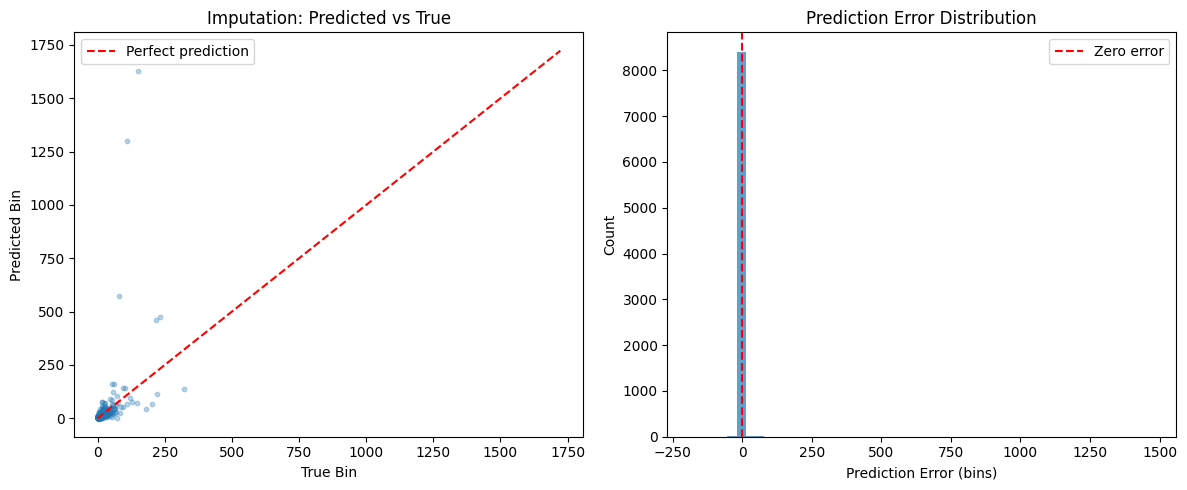

In [41]:
# Visualize predictions vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
axes[0].scatter(
    original_masked.cpu().numpy(),
    predicted_masked.cpu().numpy(),
    alpha=0.3,
    s=10
)
axes[0].plot([0, NUM_BINS], [0, NUM_BINS], 'r--', label='Perfect prediction')
axes[0].set_xlabel('True Bin')
axes[0].set_ylabel('Predicted Bin')
axes[0].set_title('Imputation: Predicted vs True')
axes[0].legend()

# Error distribution
errors = (predicted_masked - original_masked).cpu().numpy()
axes[1].hist(errors, bins=50, alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error (bins)')
axes[1].set_ylabel('Count')
axes[1].set_title('Prediction Error Distribution')
axes[1].legend()

plt.tight_layout()
fig.savefig(checkpoint_dir / "imputation_scatter_hist.png", dpi=150, bbox_inches='tight')
plt.show()
# these are for the masked genes in the cell states. 

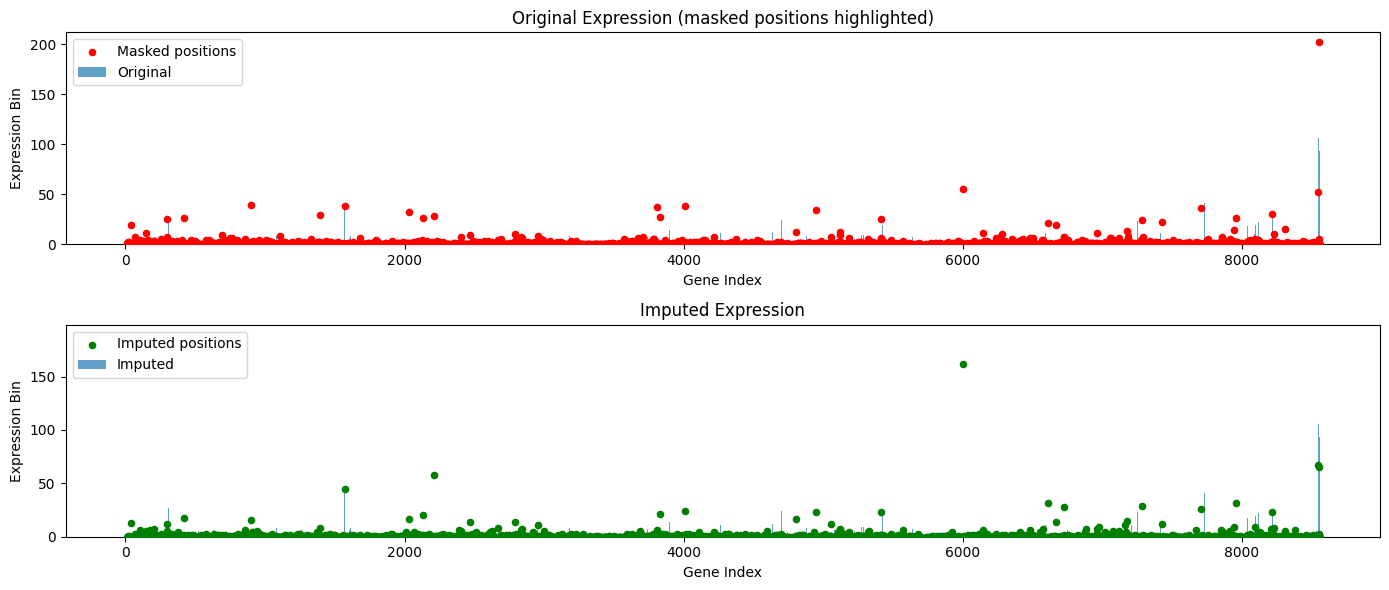

Cell 0 - Accuracy: 51.26%, MAE: 1.10 bins


27

In [42]:
# Single cell example
cell_idx = 0
original_cell = test_batch[cell_idx].cpu().numpy()
imputed_cell = imputed[cell_idx].cpu().numpy()
cell_mask = mask[cell_idx].cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Plot expression profiles
gene_indices = np.arange(len(original_cell))

# Original
axes[0].bar(gene_indices, original_cell, alpha=0.7, label='Original', width=1.0)
axes[0].scatter(gene_indices[cell_mask], original_cell[cell_mask], 
                c='red', s=20, zorder=5, label='Masked positions')
axes[0].set_xlabel('Gene Index')
axes[0].set_ylabel('Expression Bin')
axes[0].set_title('Original Expression (masked positions highlighted)')
axes[0].legend()

# Imputed
axes[1].bar(gene_indices, imputed_cell, alpha=0.7, label='Imputed', width=1.0)
axes[1].scatter(gene_indices[cell_mask], imputed_cell[cell_mask], 
                c='green', s=20, zorder=5, label='Imputed positions')
axes[1].set_xlabel('Gene Index')
axes[1].set_ylabel('Expression Bin')
axes[1].set_title('Imputed Expression')
axes[1].legend()

plt.tight_layout()
fig.savefig(checkpoint_dir / f"single_cell_{cell_idx}.png", dpi=150, bbox_inches='tight')
plt.show()

# Calculate cell-specific accuracy
cell_acc = (original_cell[cell_mask] == imputed_cell[cell_mask]).mean()
cell_mae = np.abs(original_cell[cell_mask] - imputed_cell[cell_mask]).mean()
print(f'Cell {cell_idx} - Accuracy: {cell_acc:.2%}, MAE: {cell_mae:.2f} bins')

# Save cell-specific metrics
(checkpoint_dir / f"cell_{cell_idx}_acc.txt").write_text(f"{cell_acc:.6f}\n")
(checkpoint_dir / f"cell_{cell_idx}_mae.json").write_text(f"{{\n  \"mae_bins\": {cell_mae:.6f}\n}}\n")

In [43]:
from sedd.sampling import EulerSampler

# Create sampler for generation
sampler = EulerSampler(
    model=model,
    graph=graph,
    noise=noise,
    num_steps=100,
    device=device,
    temperature=1.0
)

# Generate from all-masked starting point
num_generate = 5
x_init = graph.sample_limiting((num_generate, NUM_GENES), device)

print(f'Initial (all masked): {x_init}')

generated = sampler.sample(x_init, show_progress=True)
print(f'Generated shape: {generated.shape}')

Initial (all masked): tensor([[1723, 1723, 1723,  ..., 1723, 1723, 1723],
        [1723, 1723, 1723,  ..., 1723, 1723, 1723],
        [1723, 1723, 1723,  ..., 1723, 1723, 1723],
        [1723, 1723, 1723,  ..., 1723, 1723, 1723],
        [1723, 1723, 1723,  ..., 1723, 1723, 1723]])


Sampling: 100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Generated shape: torch.Size([5, 8563])


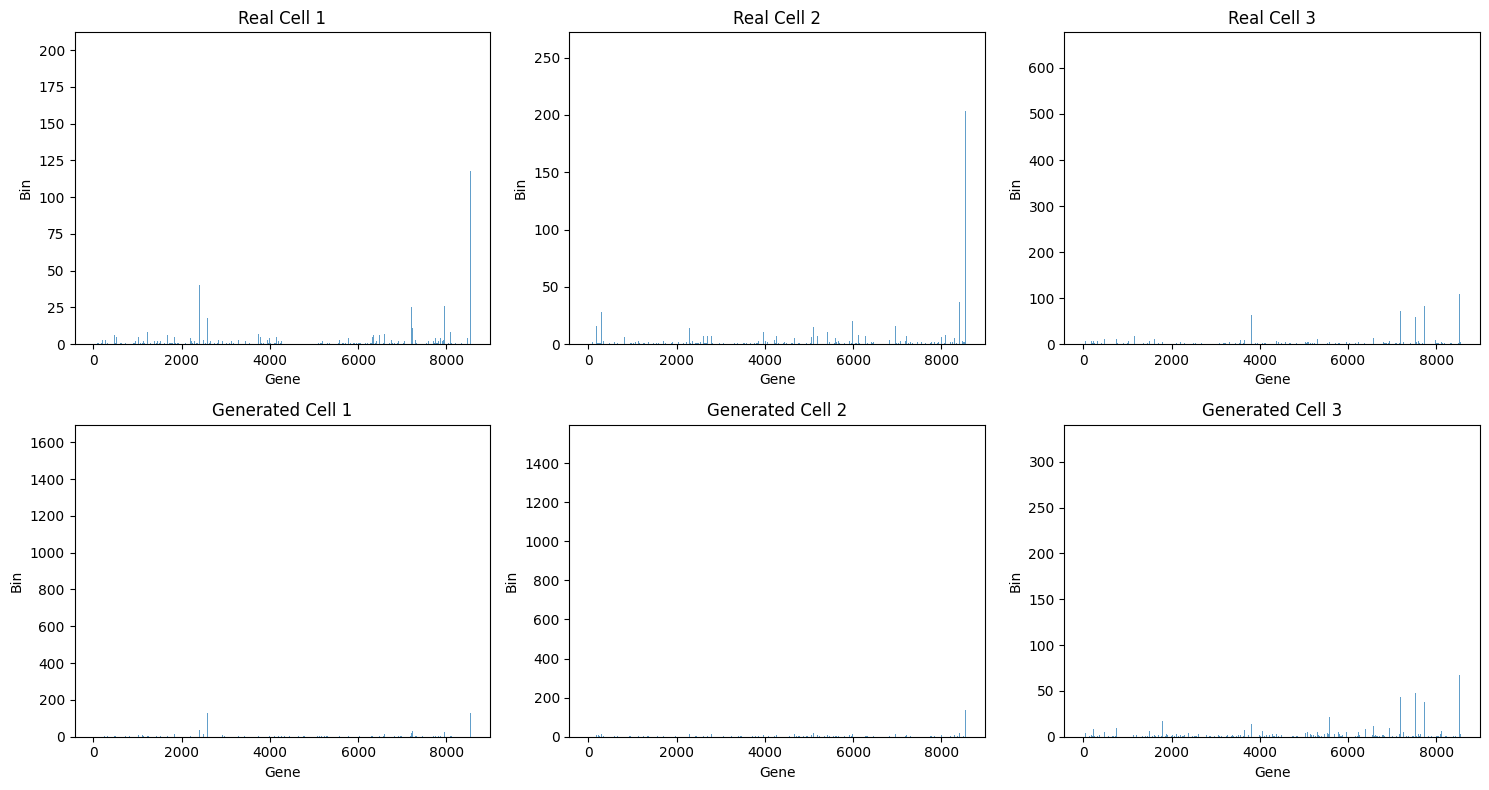

In [44]:
# Compare generated vs real cells
n_real = min(test_batch.shape[0], 3)
n_gen = min(generated.shape[0], 3)
n_cols = max(n_real, n_gen)

fig, axes = plt.subplots(2, n_cols, figsize=(5 * n_cols, 8), squeeze=False)

# Plot real cells
for i in range(n_real):
    axes[0, i].bar(range(NUM_GENES), test_batch[i].cpu().numpy(), alpha=0.7, width=1.0)
    axes[0, i].set_xlabel('Gene')
    axes[0, i].set_ylabel('Bin')
    axes[0, i].set_title(f'Real Cell {i+1}')

# Plot generated cells
for i in range(n_gen):
    axes[1, i].bar(range(NUM_GENES), generated[i].cpu().numpy(), alpha=0.7, width=1.0)
    axes[1, i].set_xlabel('Gene')
    axes[1, i].set_ylabel('Bin')
    axes[1, i].set_title(f'Generated Cell {i+1}')

plt.tight_layout()
fig.savefig(checkpoint_dir / "real_vs_generated.png", dpi=150, bbox_inches='tight')
plt.show()

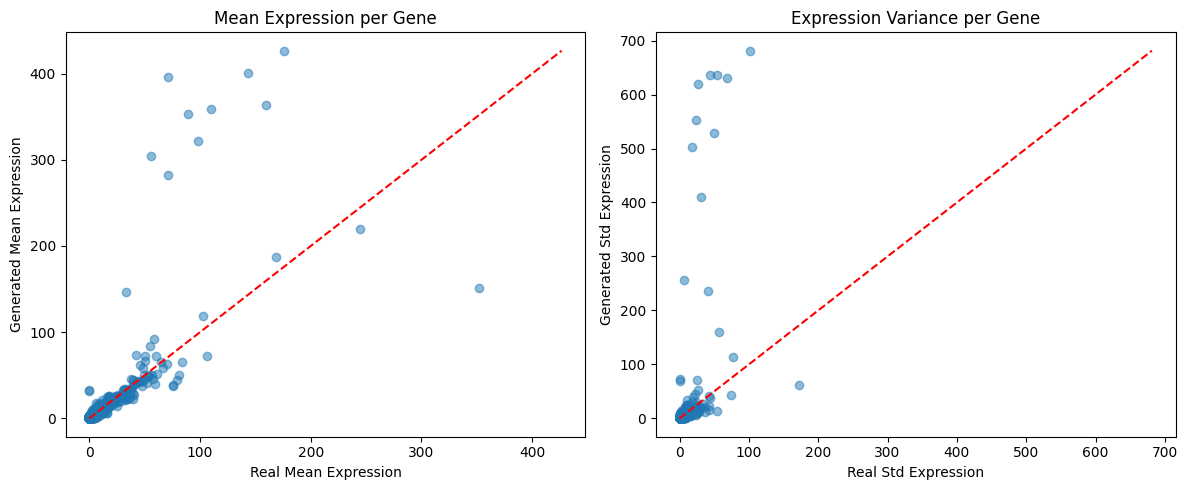

Mean expression correlation: 0.768


9

In [45]:
# Compare statistics
real_mean = test_batch.float().mean(dim=0).cpu().numpy()
gen_mean = generated.float().mean(dim=0).cpu().numpy()

real_std = test_batch.float().std(dim=0).cpu().numpy()
gen_std = generated.float().std(dim=0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(real_mean, gen_mean, alpha=0.5)
axes[0].plot([0, max(real_mean.max(), gen_mean.max())], 
             [0, max(real_mean.max(), gen_mean.max())], 'r--')
axes[0].set_xlabel('Real Mean Expression')
axes[0].set_ylabel('Generated Mean Expression')
axes[0].set_title('Mean Expression per Gene')

axes[1].scatter(real_std, gen_std, alpha=0.5)
axes[1].plot([0, max(real_std.max(), gen_std.max())], 
             [0, max(real_std.max(), gen_std.max())], 'r--')
axes[1].set_xlabel('Real Std Expression')
axes[1].set_ylabel('Generated Std Expression')
axes[1].set_title('Expression Variance per Gene')

plt.tight_layout()
fig.savefig(checkpoint_dir / "expression_stats.png", dpi=150, bbox_inches='tight')
plt.show()

# Correlation
mean_corr = np.corrcoef(real_mean, gen_mean)[0, 1]
print(f'Mean expression correlation: {mean_corr:.3f}')

# Save summary metrics
(checkpoint_dir / "mean_corr.txt").write_text(f"{mean_corr:.6f}\n")